In [ ]:
%env WORKDIR=/tmp/vault
%env PROJECT=hc-281201381d30448688d3f0a2cdf
%env KEYRING_NAME=kmse-test
%env LOCATION=global
%env KEY_NAME=kmsekey
%env SERVICE_ACCOUNT=vaultkmse

In [ ]:
! date +%s

> ### Copy the value of the `cell` above as env in the cell below

In [ ]:
%env DATE=1733846291

In [ ]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

In [ ]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-p5fh.josemerchan-313707.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.GqTsfXwqgl0bK86WbGIfCBZz

# [KMSE](https://developer.hashicorp.com/vault/docs/secrets/key-management) and [KMSE API](https://developer.hashicorp.com/vault/api-docs/secret/key-management#key-management-secrets-engine-api)

### Enable KMSE Engine

In [ ]:
! vault secrets enable keymgmt

### Create keys that will later be sync with CSP

In [ ]:
! vault write keymgmt/key/aes256-gcm96 type="aes256-gcm96"
! vault write keymgmt/key/ecdsa-p256 type="ecdsa-p256"

In [ ]:
! vault write keymgmt/key/aes256-key2 type="aes256-gcm96"

### List generated keys

In [ ]:
! vault list keymgmt/key

### Read one of the keys

In [ ]:
! vault read -format=json keymgmt/key/aes256-gcm96 | jq

## Generate account with kms admin role permissions on GCP


### 1. Create the Service Account

In [ ]:
%%bash
gcloud iam service-accounts create $SERVICE_ACCOUNT$DATE \
    --description="Service account for KMS admin tasks" \
    --display-name=$SERVICE_ACCOUNT$DATE \
    --project=$PROJECT

### 2. Grant KMS Admin Role

In [ ]:
%%bash
gcloud projects add-iam-policy-binding $PROJECT \
    --member="serviceAccount:${SERVICE_ACCOUNT}${DATE}@${PROJECT}.iam.gserviceaccount.com" \
    --role="roles/cloudkms.admin" \
    --project=$PROJECT

### 3. Create SA cert

In [ ]:
! gcloud iam service-accounts keys create $WORKDIR/sacreds.json --iam-account=$SERVICE_ACCOUNT$DATE@$PROJECT.iam.gserviceaccount.com

### 4. Create the keyring where Vault will store the keys

In [ ]:
%%bash
gcloud kms keyrings create $KEYRING_NAME$DATE --location $LOCATION  --project=$PROJECT

## Credentials must be copied to the leader Vault node and run the command

In [ ]:
! kubectl cp $WORKDIR/sacreds.json -n vault vault-primary-0:/tmp/creds.json
! kubectl cp $WORKDIR/sacreds.json -n vault vault-primary-1:/tmp/creds.json
! kubectl cp $WORKDIR/sacreds.json -n vault vault-primary-2:/tmp/creds.json
! kubectl cp $WORKDIR/sacreds.json -n vault vault-primary-3:/tmp/creds.json
! kubectl cp $WORKDIR/sacreds.json -n vault vault-primary-4:/tmp/creds.json

[Key compatibility with GCP](https://developer.hashicorp.com/vault/docs/secrets/key-management/gcpkms#key-purpose-compatability) and [GCP Setup Guide](https://developer.hashicorp.com/vault/docs/secrets/gcpkms)

In [ ]:
%%bash

vault write keymgmt/kms/gcpckms \
    provider="gcpckms" \
    key_collection="projects/${PROJECT}/locations/${LOCATION}/keyRings/${KEYRING_NAME}${DATE}" \
    credentials=service_account_file=/tmp/creds.json

### Sync Keys

In [ ]:
%%bash

vault write keymgmt/kms/gcpckms/key/aes256-gcm96 \
    purpose="encrypt,decrypt" \
    protection="software"

In [ ]:
%%bash

vault write keymgmt/kms/gcpckms/key/ecdsa-p256 \
    purpose="sign" \
    protection="software"

In [ ]:
%%bash
vault write keymgmt/kms/gcpckms/key/aes256-key2 \
    purpose="encrypt,decrypt" \
    protection="software"

### Got to Key Management GCP Console



In [ ]:
! echo "https://console.cloud.google.com/security/kms/keyring/manage/${LOCATION}/${KEYRING_NAME}${DATE}/key?project=${PROJECT}"

### List Synced Keys

In [ ]:
! vault list keymgmt/kms/gcpckms/key/

### Rotate Keys

In [ ]:
! vault write -f keymgmt/key/aes256-gcm96/rotate

In [ ]:
!  vault read -format=json keymgmt/key/aes256-gcm96 | jq 

> This [engine](https://developer.hashicorp.com/vault/docs/secrets/gcpkms#faq) was created before the functionality of [managed keys](https://developer.hashicorp.com/vault/docs/enterprise/managed-keys)

# Clean UP

### Remove keys from GCP

In [ ]:
%%bash
vault delete keymgmt/kms/gcpckms/key/aes256-key2
vault delete keymgmt/kms/gcpckms/key/ecdsa-p256
vault delete keymgmt/kms/gcpckms/key/aes256-gcm96

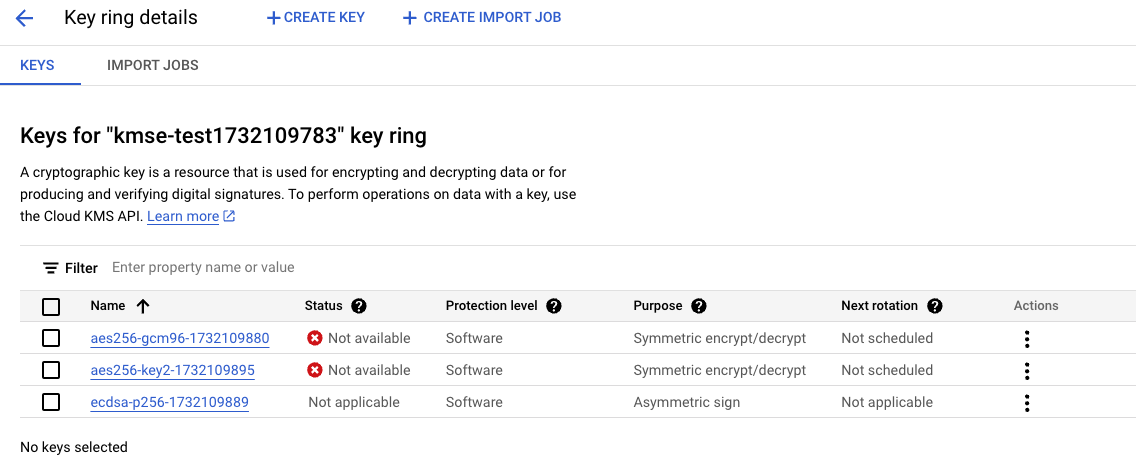

### Remove keys from Vault. If deletion has been set

In [ ]:
vault delete keymgmt/key/aes256-key2
vault delete keymgmt/key/ecdsa-p256
vault delete keymgmt/key/aes256-gcm96

### Disable Engine

In [ ]:
! vault secrets disable keymgmt

### Remove GCP SA

In [ ]:
! gcloud iam service-accounts delete $SERVICE_ACCOUNT$DATE@$PROJECT.iam.gserviceaccount.com --project=$PROJECT --quiet